## Encoder-Free Speech LLM Inference Demo


This notebook demonstrates an **encoder-free** speech recognition system that eliminates the traditional speech encoder (e.g., Whisper ~1.5B params), replacing it with a lightweight CNN projector (~6M params) that maps mel spectrograms directly to a frozen Llama-3.2-3B language model.


### Table of Contents

1. [Environment Setup](#1-environment-setup)
2. [Model Configuration](#2-model-configuration)
3. [Model Architecture](#3-model-architecture)
4. [Audio Feature Extraction Pipeline](#4-audio-feature-extraction-pipeline)
5. [Inference Pipeline](#5-inference-pipeline)
6. [Transcription Results](#6-transcription-results)
7. [Decoding Strategy Comparison](#7-decoding-strategy-comparison)
8. [Projector Analysis](#8-projector-analysis)
9. [Summary](#9-summary)

In [18]:
import os
import sys
import torch
import numpy as np
import librosa
import librosa.display
import soundfile as sf
import IPython.display as ipd
import matplotlib.pyplot as plt
from omegaconf import OmegaConf

# Add project root to path
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from models.model import model_builder

print(f"Project root : {PROJECT_ROOT}")
print(f"PyTorch      : {torch.__version__}")
print(f"CUDA         : {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU          : {torch.cuda.get_device_name(0)}")
    print(f"VRAM         : {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Project root : p:\Programming\EfficientAudioLM
PyTorch      : 2.8.0+cu126
CUDA         : True
GPU          : NVIDIA GeForce RTX 4060 Laptop GPU
VRAM         : 8.6 GB


---
## 2. Model Configuration

In [19]:
# ============================================================
# CONFIGURE THESE PATHS
# ============================================================

# Path to your trained projector checkpoint
CHECKPOINT_PATH = os.path.join(PROJECT_ROOT, "output", "projector_best_wer.pt")

# Path to audio file for transcription
AUDIO_PATH = os.path.join(PROJECT_ROOT, "audio", "sample.wav")

# Config file (cnn-fuyu large: 384ch, k=7, 4x downsampling)
CONFIG_PATH = os.path.join(PROJECT_ROOT, "configs", "exp2_cnn_fuyu_large.yaml")

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Config:     {CONFIG_PATH}")
print(f"Checkpoint: {CHECKPOINT_PATH}")
print(f"Audio:      {AUDIO_PATH}")
print(f"Device:     {DEVICE}")

Config:     p:\Programming\EfficientAudioLM\configs\exp2_cnn_fuyu_large.yaml
Checkpoint: p:\Programming\EfficientAudioLM\output\projector_best_wer.pt
Audio:      p:\Programming\EfficientAudioLM\audio\sample.wav
Device:     cuda


In [20]:
# Load configuration
cfg = OmegaConf.load(CONFIG_PATH)

print("Configuration Summary")
print("=" * 50)
print(f"{'Parameter':<25} {'Value'}")
print("-" * 50)
print(f"{'Projector':<25} {cfg.model.projector}")
print(f"{'LLM':<25} {cfg.model.llm_model}")
print(f"{'LLM Dimension':<25} {cfg.model.llm_dim}")
print(f"{'Mel Bins':<25} {cfg.model.mel_size}")
print(f"{'CNN Channels':<25} {cfg.model.cnn_channels}")
print(f"{'CNN Kernel Size':<25} {cfg.model.cnn_kernel_size}")
print(f"{'Downsample Factor':<25} 4x (stride 2 x 2 layers)")
print(f"{'Input Normalization':<25} {cfg.data.mel_input_norm}")
print(f"{'Projector Dropout':<25} {cfg.model.mel_dropout}")
print(f"{'LLM Frozen':<25} {cfg.train.freeze_llm}")
print(f"{'Mixed Precision':<25} {cfg.train.mixed_precision}")
print("=" * 50)

Configuration Summary
Parameter                 Value
--------------------------------------------------
Projector                 cnn-fuyu
LLM                       meta-llama/Llama-3.2-3B
LLM Dimension             3072
Mel Bins                  80
CNN Channels              384
CNN Kernel Size           7
Downsample Factor         4x (stride 2 x 2 layers)
Input Normalization       True
Projector Dropout         0.1
LLM Frozen                True
Mixed Precision           True


In [21]:
# Build model: Projector + LLM
# If CHECKPOINT_PATH is set, it loads the trained projector weights.
# Otherwise, projector uses random initialization (for testing the pipeline).

ckpt = CHECKPOINT_PATH if CHECKPOINT_PATH and os.path.exists(CHECKPOINT_PATH) else None

if ckpt is None:
    print("NOTE: No checkpoint provided. Projector uses random initialization.")
    print("      Transcription outputs will be nonsensical until a trained")
    print("      checkpoint is loaded via CHECKPOINT_PATH.\n")

model, tokenizer = model_builder(
    cfg.train,
    cfg.model,
    ckpt_path=ckpt,
    data_config=cfg.data,
)

model = model.to(DEVICE)
model.eval()

# Parameter summary
proj_params = sum(p.numel() for p in model.projector.parameters())
llm_params = sum(p.numel() for p in model.llm.parameters())
total_params = proj_params + llm_params

print(f"\nParameter Summary")
print(f"{'=' * 50}")
print(f"{'Component':<25} {'Parameters':>15}")
print(f"{'-' * 50}")
print(f"{'CNN Projector':<25} {proj_params:>15,}")
print(f"{'Llama-3.2-3B (frozen)':<25} {llm_params:>15,}")
print(f"{'-' * 50}")
print(f"{'Total':<25} {total_params:>15,}")
print(f"{'Trainable (projector)':<25} {proj_params:>15,}  ({proj_params/total_params*100:.2f}%)")
print(f"{'=' * 50}")


CNNFuyuProjector (CNN Downsampler + Fuyu + PosEmb)
  Mel Dim: 80
  CNN Channels: 384
  Kernel Size: 7
  Downsampling: 4x (stride 2 × 2 layers)
  LLM Dim: 3072
  Max Positions: 750 (~30.0s audio)
  Dropout: 0.1
  Architecture: mel[80] → CNN[384] → Linear → +PosEmb → [3072]
  Parameters: 4,742,400
    - CNN: 1,249,536
    - Projection: 1,182,720
    - PosEmb: 2,304,000



Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 31.89it/s]



Parameter Summary
Component                      Parameters
--------------------------------------------------
CNN Projector                   4,742,400
Llama-3.2-3B (frozen)       3,212,749,824
--------------------------------------------------
Total                       3,217,492,224
Trainable (projector)           4,742,400  (0.15%)


### 4. Audio Feature Extraction Pipeline



In [22]:
# Feature extraction parameters (must match training config exactly)
SAMPLE_RATE = 16000       # 16kHz — standard for speech
N_FFT = 400               # 25ms window at 16kHz
HOP_LENGTH = 160          # 10ms hop -> 100 frames/second
WIN_LENGTH = 400          # 25ms analysis window
N_MELS = cfg.data.mel_size  # 80 mel-frequency bins
FMIN = 0                  # Lowest mel frequency
FMAX = 8000               # Highest mel frequency (Nyquist/2)
MAX_AUDIO_SECONDS = 30.0  # Maximum audio duration


def load_and_process_audio(audio_path):
    """
    Extract normalized log-mel spectrogram from an audio file.
    
    Follows the identical pipeline as SpeechDatasetJsonl in
    datamodule/dataset.py to ensure train-inference consistency.
    
    Args:
        audio_path: Path to audio file (WAV, FLAC, etc.)
        
    Returns:
        audio_raw: Raw audio waveform as numpy array (padded/trimmed)
        log_mel:   Normalized log-mel spectrogram [T, 80] as torch.Tensor
    """
    # Step 1: Load and resample to 16kHz
    audio, sr = librosa.load(audio_path, sr=SAMPLE_RATE)
    original_duration = len(audio) / sr
    
    # Step 2: Pad or trim to fixed 30s length
    target_samples = int(MAX_AUDIO_SECONDS * SAMPLE_RATE)
    if len(audio) > target_samples:
        audio = audio[:target_samples]
    elif len(audio) < target_samples:
        audio = np.pad(audio, (0, target_samples - len(audio)), mode='constant')
    
    # Step 3-4: Power mel spectrogram + log scaling
    mel_spec = librosa.feature.melspectrogram(
        y=audio, sr=SAMPLE_RATE,
        n_fft=N_FFT, hop_length=HOP_LENGTH, win_length=WIN_LENGTH,
        n_mels=N_MELS, fmin=FMIN, fmax=FMAX, power=2.0,
    )
    log_mel = librosa.power_to_db(mel_spec, ref=np.max)  # [n_mels, T]
    log_mel = torch.from_numpy(log_mel.T).float()         # [T, n_mels]
    
    # Step 5: Per-channel normalization using training set statistics
    if cfg.data.mel_input_norm:
        stats_dir = os.path.join(PROJECT_ROOT, cfg.data.mel_stats_path)
        mel_means = torch.from_numpy(
            np.load(os.path.join(stats_dir, 'mel_means_train_100h.npy'))
        ).float()
        mel_stds = torch.from_numpy(
            np.load(os.path.join(stats_dir, 'mel_stds_train_100h.npy'))
        ).float()
        log_mel = (log_mel - mel_means) / (mel_stds + 1e-8)
    
    print(f"Audio: {os.path.basename(audio_path)}")
    print(f"  Original duration : {original_duration:.2f}s")
    print(f"  Waveform samples  : {len(audio):,}")
    print(f"  Mel shape         : {tuple(log_mel.shape)} (frames x mel_bins)")
    print(f"  Frame rate        : {SAMPLE_RATE // HOP_LENGTH} fps (10ms/frame)")
    print(f"  Normalized        : {cfg.data.mel_input_norm}")
    
    return audio, log_mel


# Extract features from the demo audio sample
audio_raw, audio_mel = load_and_process_audio(AUDIO_PATH)

Audio: sample.wav
  Original duration : 18.36s
  Waveform samples  : 480,000
  Mel shape         : (3001, 80) (frames x mel_bins)
  Frame rate        : 100 fps (10ms/frame)
  Normalized        : True


In [23]:
# Listen to the audio
print("Audio playback:")
ipd.display(ipd.Audio(audio_raw, rate=SAMPLE_RATE))

Audio playback:


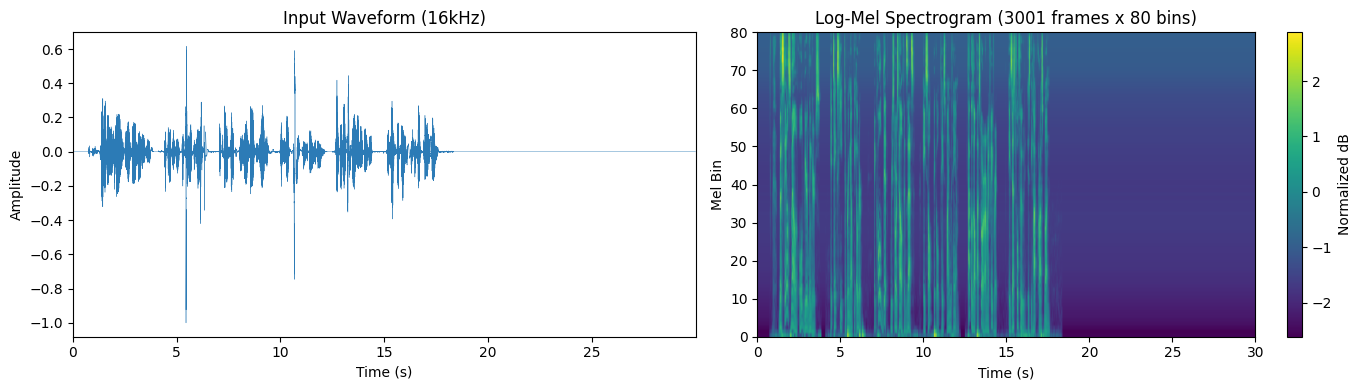

In [24]:
# Visualization: waveform and mel spectrogram
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Waveform
t = np.arange(len(audio_raw)) / SAMPLE_RATE
axes[0].plot(t, audio_raw, linewidth=0.3, color='#2c7bb6')
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Amplitude")
axes[0].set_title("Input Waveform (16kHz)")
axes[0].set_xlim(0, t[-1])

# Mel spectrogram (with proper time axis)
mel_display = audio_mel.numpy().T  # [mel_bins, T]
im = axes[1].imshow(mel_display, aspect='auto', origin='lower', cmap='viridis',
                     extent=[0, mel_display.shape[1] * HOP_LENGTH / SAMPLE_RATE, 0, N_MELS])
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Mel Bin")
axes[1].set_title(f"Log-Mel Spectrogram ({audio_mel.shape[0]} frames x {audio_mel.shape[1]} bins)")
plt.colorbar(im, ax=axes[1], label="Normalized dB" if cfg.data.mel_input_norm else "dB")

plt.tight_layout()
plt.show()

### 5. Inference Pipeline

In [25]:
@torch.no_grad()
def transcribe(model, tokenizer, audio_mel, prompt="Transcribe speech to text.",
               max_new_tokens=200, num_beams=4, device="cuda"):
    """
    Perform encoder-free speech transcription.
    
    This function bypasses the model's built-in inference() method
    (which assumes a Whisper encoder) and directly implements the
    projector -> LLM pipeline for encoder-free operation.
    
    Args:
        model:          ASRLLM model instance (projector + LLM)
        tokenizer:      LLM tokenizer (Llama-3.2 tokenizer)
        audio_mel:      Log-mel spectrogram tensor [T, mel_bins]
        prompt:         Instruction prompt for the LLM
        max_new_tokens: Maximum tokens to generate
        num_beams:      Beam width for beam search (1 = greedy decoding)
        device:         Computation device (cuda/cpu)
        
    Returns:
        transcription:  Decoded text string
        metadata:       Dict with dimension trace through the pipeline
    """
    # --- Stage 1: Acoustic Projection ---
    # Project mel spectrogram into LLM embedding space via CNN projector
    # mel [T, 80] -> [1, T, 80] -> projector -> [1, T/4, 3072]
    mel_input = audio_mel.unsqueeze(0).to(device)
    projector_dtype = next(model.projector.parameters()).dtype
    mel_input = mel_input.to(projector_dtype)
    
    audio_embeds = model.projector(mel_input)  # [1, T/4, llm_dim]
    
    # Match LLM dtype (projector is float32, LLM may be bfloat16)
    llm_dtype = next(model.llm.parameters()).dtype
    audio_embeds = audio_embeds.to(llm_dtype)
    
    # --- Stage 2: Prompt Embedding ---
    # Tokenize and embed the instruction prompt using the same template as training
    prompt_text = f"USER: {prompt}\n ASSISTANT:"
    prompt_ids = tokenizer.encode(prompt_text)
    prompt_ids = torch.tensor(prompt_ids, dtype=torch.int64).to(device)
    
    # Resolve the LLM's embedding layer (handles different HuggingFace model wrappers)
    if hasattr(model.llm, 'model') and hasattr(model.llm.model, 'embed_tokens'):
        prompt_embeds = model.llm.model.embed_tokens(prompt_ids)
    elif hasattr(model.llm, 'model') and hasattr(model.llm.model, 'model'):
        prompt_embeds = model.llm.model.model.embed_tokens(prompt_ids)
    else:
        prompt_embeds = model.llm.model.model.model.embed_tokens(prompt_ids)
    
    prompt_embeds = prompt_embeds.unsqueeze(0)  # [1, P, llm_dim]
    
    # --- Stage 3: Concatenation ---
    # Combine: [audio_embeddings ; prompt_embeddings] -> LLM input
    inputs_embeds = torch.cat([audio_embeds, prompt_embeds], dim=1)
    attention_mask = torch.ones(
        inputs_embeds.shape[:-1], dtype=torch.long, device=device
    )
    
    # --- Stage 4: Autoregressive Generation ---
    output_ids = model.llm.generate(
        inputs_embeds=inputs_embeds,
        attention_mask=attention_mask,
        max_new_tokens=max_new_tokens,
        num_beams=num_beams,
        do_sample=False,
        repetition_penalty=1.0,
        length_penalty=1.0,
        temperature=1.0,
        bos_token_id=tokenizer.bos_token_id,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.pad_token_id,
    )
    
    # --- Stage 5: Token Decoding ---
    transcription = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    
    # Metadata for dimension tracing / analysis
    metadata = {
        "mel_frames": audio_mel.shape[0],
        "mel_bins": audio_mel.shape[1],
        "projected_length": audio_embeds.shape[1],
        "prompt_tokens": len(prompt_ids),
        "total_input_length": inputs_embeds.shape[1],
        "generated_tokens": output_ids.shape[1],
        "embedding_dim": inputs_embeds.shape[2],
    }
    
    return transcription, metadata

---
## 6. Transcription Results

We run beam search inference on the demo audio sample and trace tensor dimensions through each stage of the pipeline.

In [26]:
# ----- Transcription Results -----

print("Running inference...\n")

transcription, meta = transcribe(
    model=model,
    tokenizer=tokenizer,
    audio_mel=audio_mel,
    prompt="Transcribe speech to text.",
    max_new_tokens=200,
    num_beams=4,
    device=DEVICE,
)

# Dimension trace through the full pipeline
print("Dimension Trace Through Pipeline")
print("=" * 60)
print(f"  Mel spectrogram       : [{meta['mel_frames']}, {meta['mel_bins']}]")
print(f"  After projector (4x)  : [{meta['projected_length']}, {meta['embedding_dim']}]")
print(f"  Prompt tokens         : {meta['prompt_tokens']}")
print(f"  LLM input sequence    : [{meta['total_input_length']}, {meta['embedding_dim']}]")
print(f"  Generated tokens      : {meta['generated_tokens']}")
print("=" * 60)
print(f"\nTranscription:\n")
print(f"  {transcription}")

Running inference...



KeyboardInterrupt: 

---
## 7. Decoding Strategy Comparison

We compare two decoding strategies:
- **Greedy decoding** (`num_beams=1`): Selects the highest-probability token at each step. Faster but may miss globally optimal sequences.
- **Beam search** (`num_beams=4`): Maintains top-$k$ hypotheses at each step and selects the best complete sequence. Slower but generally more accurate for ASR, as it can recover from locally suboptimal token choices.

In [ ]:
import time

results = {}
for strategy, beams in [("Greedy (beams=1)", 1), ("Beam search (beams=4)", 4)]:
    start = time.time()
    text, info = transcribe(
        model, tokenizer, audio_mel,
        num_beams=beams, max_new_tokens=200, device=DEVICE,
    )
    elapsed = time.time() - start
    results[strategy] = {"text": text, "time": elapsed, "tokens": info["generated_tokens"]}

print(f"Decoding Strategy Comparison")
print("=" * 70)
for strategy, r in results.items():
    print(f"\n  {strategy}")
    print(f"  {'Latency':<20}: {r['time']:.2f}s")
    print(f"  {'Tokens generated':<20}: {r['tokens']}")
    print(f"  {'Output':<20}: {r['text']}")
print("\n" + "=" * 70)

---
## 8. Projector Analysis

Since the CNN projector is the **only trained component**, we inspect its learned parameters and intermediate representations to understand what acoustic patterns it captures.

In [ ]:
# 8.1 Layer-by-layer parameter breakdown
print("CNNFuyuProjector (Large) — Layer Details")
print("=" * 65)
for name, param in model.projector.named_parameters():
    print(f"  {name:<35} {str(tuple(param.shape)):<20} {param.numel():>8,} params")
print(f"  {'-' * 65}")
total = sum(p.numel() for p in model.projector.parameters())
print(f"  {'Total':<35} {'':20} {total:>8,} params")

In [ ]:
# 8.2 Visualize learned Conv1d filters
# The CNN has 2 Conv1d layers. Layer 1 (cnn[0]) maps mel bins to CNN channels.
# Each filter has shape [in_channels=80, kernel_size=7], representing a
# learned ~70ms acoustic pattern detector across all mel frequency bins.

conv1_weights = model.projector.cnn[0].weight.detach().cpu().float().numpy()
print(f"CNN Layer 1 weight shape: {conv1_weights.shape}  (out_channels, in_channels, kernel_size)")

fig, axes = plt.subplots(2, 4, figsize=(16, 6))
fig.suptitle("Learned Conv1d Filters — Layer 1 (8 of 384 output channels)
"
             "Each filter: 80 mel bins x 7 time steps (~70ms receptive field)", fontsize=12)

for i, ax in enumerate(axes.flat):
    im = ax.imshow(conv1_weights[i], aspect='auto', cmap='RdBu_r', origin='lower')
    ax.set_title(f"Filter {i}", fontsize=9)
    ax.set_xlabel("Time step")
    if i % 4 == 0:
        ax.set_ylabel("Mel bin")
    plt.colorbar(im, ax=ax, fraction=0.046)

plt.tight_layout()
plt.show()

In [ ]:
# 8.3 Visualize intermediate representations through the projector
# This shows how the mel spectrogram is progressively transformed
# into LLM-compatible embeddings through the 2-layer CNN.

with torch.no_grad():
    mel_input = audio_mel.unsqueeze(0).to(DEVICE)
    projector_dtype = next(model.projector.parameters()).dtype
    mel_input = mel_input.to(projector_dtype)
    
    # Stage-by-stage forward pass through projector internals
    x = mel_input.transpose(1, 2)                                  # [1, 80, T]
    x_cnn = model.projector.cnn(x)                                  # [1, 384, T/4]
    x_cnn_t = x_cnn.transpose(1, 2)                                # [1, T/4, 384]
    x_proj = model.projector.projection(x_cnn_t)                   # [1, T/4, 3072]
    x_final = model.projector(mel_input)                            # [1, T/4, 3072]

fig, axes = plt.subplots(3, 1, figsize=(14, 8))

# Input mel spectrogram
axes[0].imshow(mel_input[0].cpu().float().numpy().T, aspect='auto', origin='lower', cmap='viridis')
axes[0].set_title(f"Input: Mel Spectrogram [{mel_input.shape[1]} frames, {mel_input.shape[2]} bins]")
axes[0].set_ylabel("Mel Bin")

# After 2-layer CNN (first 64 of 384 channels)
axes[1].imshow(x_cnn_t[0, :, :64].cpu().float().numpy().T, aspect='auto', origin='lower', cmap='viridis')
axes[1].set_title(f"After 2-Layer CNN (4x downsample) [{x_cnn_t.shape[1]} frames, showing 64/{x_cnn_t.shape[2]} channels]")
axes[1].set_ylabel("Channel")

# Final projector output (first 64 of 3072 dims)
axes[2].imshow(x_final[0, :, :64].cpu().float().numpy().T, aspect='auto', origin='lower', cmap='viridis')
axes[2].set_title(f"Final Projector Output [{x_final.shape[1]} frames, showing 64/{x_final.shape[2]} LLM dims]")
axes[2].set_ylabel("LLM Dim")
axes[2].set_xlabel("Frame")

plt.tight_layout()
plt.show()

print(f"
Projector Dimension Trace:")
print(f"  Input mel        : {tuple(mel_input.shape)}")
print(f"  After CNN (4x ds): {tuple(x_cnn.shape)}  (4x temporal downsampling)")
print(f"  After Linear     : {tuple(x_proj.shape)}  (projected to LLM dim)")
print(f"  Final output     : {tuple(x_final.shape)}  (+ pos embeddings + LayerNorm)")